# Analysis of Local and Central DP-GMM

In this notebook we will compare our DP-GMM implementations.

## Imports

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import sys
import os

# add src to path for easier local imports
sys.path.append(os.path.join(os.getcwd(), "src"))
from base_gmm import GMM
from ldp_gmm import LDPGMM

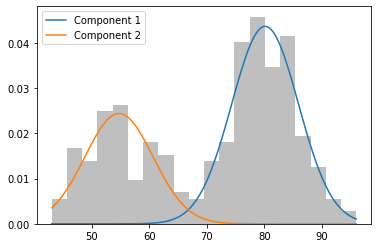

In [2]:
# read in data
df = pd.read_csv("data/old_faithful.csv")
wait_dat = df["waiting"].values.astype(int)

# create non-DP GMM object and fit to data
nondp_gmm = GMM(n_components=2)
nondp_gmm.fit(wait_dat.reshape(-1, 1))
nondp_gmm.plot_mixture(bins=20)

In [3]:
# get non-DP GMM components
nondp_means = nondp_gmm.means_.flatten()
nondp_covs = nondp_gmm.covariances_.flatten()
nondp_weights = nondp_gmm.weights_.flatten()
nondp_comp1 = (nondp_means[0], nondp_covs[0], nondp_weights[0])
nondp_comp2 = (nondp_means[1], nondp_covs[1], nondp_weights[1])
print(f"True means: {nondp_means[0], nondp_means[1]}")
print(f"True covariances: {nondp_covs[0], nondp_covs[1]}")
print(f"True weights: {nondp_weights[0], nondp_weights[1]}")

True means: (80.14546556133249, 54.699842709202834)
True covariances: (33.79021579256459, 35.31764935665251)
True weights: (0.6365423321901911, 0.3634576678098091)


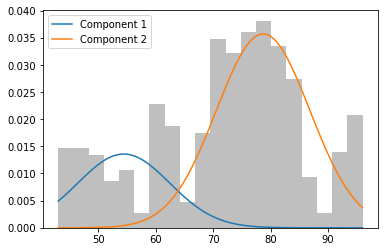

In [4]:
# create local-DP GMM object and fit to data
ldp_gmm = LDPGMM(n_components=2, epsilon=1)
ldp_gmm.fit_ldp(wait_dat.reshape(-1, 1))
ldp_gmm.plot_mixture(bins=20)

In [5]:
# get locaL-DP GMM components
ldp_means = ldp_gmm.means_.flatten()
ldp_covs = ldp_gmm.covariances_.flatten()
ldp_weights = ldp_gmm.weights_.flatten()
ldp_comp1 = (ldp_means[0], ldp_covs[0], ldp_weights[0])
ldp_comp2 = (ldp_means[1], ldp_covs[1], ldp_weights[1])
print(f"LDP means: {ldp_means[0], ldp_means[1]}")
print(f"LDP covariances: {ldp_covs[0], ldp_covs[1]}")
print(f"LDP weights: {ldp_weights[0], ldp_weights[1]}")

LDP means: (54.4215509144258, 78.69030674839668)
LDP covariances: (64.05754415801894, 66.0546491631665)
LDP weights: (0.27253418588466755, 0.7274658141153342)


Compare non-DP and local-DP mixtures.

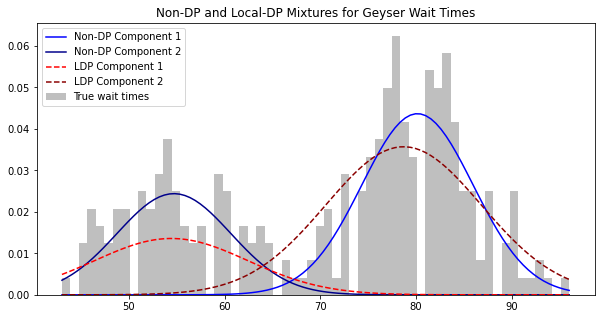

In [6]:
x = np.linspace(wait_dat.min(), wait_dat.max(), 100)
plt.figure(figsize=(10, 5))
plt.hist(wait_dat, bins=60, density=True, color="gray", alpha=0.5, label="True wait times")
plt.plot(x, nondp_comp1[2]*sp.stats.norm(nondp_comp1[0], nondp_comp1[1]**0.5).pdf(x), color="blue", label="Non-DP Component 1")
plt.plot(x, nondp_comp2[2]*sp.stats.norm(nondp_comp2[0], nondp_comp2[1]**0.5).pdf(x), color="darkblue", label="Non-DP Component 2")
plt.plot(x, ldp_comp1[2]*sp.stats.norm(ldp_comp1[0], ldp_comp1[1]**0.5).pdf(x), color="red", label="LDP Component 1", linestyle="--")
plt.plot(x, ldp_comp2[2]*sp.stats.norm(ldp_comp2[0], ldp_comp2[1]**0.5).pdf(x), color="darkred", label="LDP Component 2", linestyle="--")
plt.title("Non-DP and Local-DP Mixtures for Geyser Wait Times")
plt.legend()
plt.show()

0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished
10 finished
11 finished
12 finished
13 finished
14 finished
15 finished
16 finished
17 finished
18 finished
19 finished


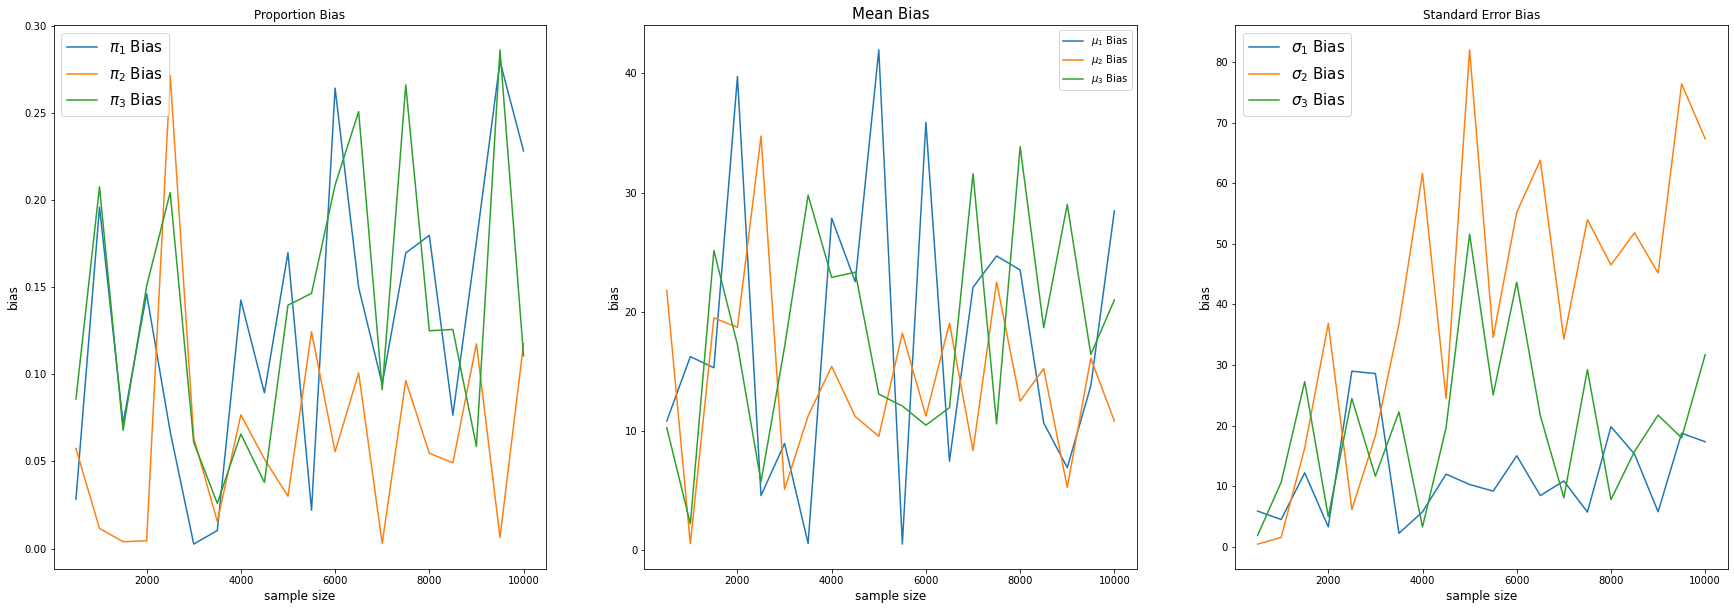

In [7]:
# Simulations
def get_params(data, n_components, epsilon, DP = False):
    if DP:
        model = LDPGMM(n_components = n_components, epsilon = epsilon)
        model.fit_ldp(data.reshape(-1,1))
        
        dists = np.zeros((n_components, 3))
        for i in range(n_components):
            dists[i,:] = [model.means_[i][0],model.covariances_[i][0][0], model.weights_[i]]
    else:
        model = LDPGMM(n_components = n_components)
        model.fit(data.reshape(-1,1))
        
        dists = np.zeros((n_components, 3))
        for i in range(n_components):
            dists[i,:] = [model.means_[i][0],model.covariances_[i][0][0], model.weights_[i]]
    return dists


# Simulations
samples = 20
components = 3
epsilon = 4
iters = 10

ns = np.linspace(500,10000, samples).astype(int)

dp_dist1 = np.zeros((samples,components))
dp_dist2 = np.zeros((samples,components))
dp_dist3 = np.zeros((samples,components))

true_dist1 = np.zeros((samples,components))
true_dist2 = np.zeros((samples,components))
true_dist3 = np.zeros((samples,components))

dp_dists_list = [dp_dist1, dp_dist2, dp_dist3]
true_dists_list = [true_dist1, true_dist2, true_dist3]

for i,n in enumerate(ns):
    #Create random data with distributions
    pis = [0.2, 0.4, 0.4]
    mus = [17, 30, 50]
    sigmas = [5**2, 4**2, 5**2]
    K = len(pis)
    zs = np.random.choice(np.arange(K), size=n, p=pis)
    # Make hist integers because that's what the local model handles
    y = np.array([np.random.normal(mus[z], sigmas[z]**0.5, 1)[0] for z in zs]).astype(int)
    
    true_dists = get_params(y, components, epsilon)
    
    dist1_trial = np.zeros((iters,components))
    dist2_trial = np.zeros((iters,components))
    dist3_trial = np.zeros((iters,components))
    #dp_dists = get_params(y, components, epsilon, DP = True)
    for k in range(iters):
        dp_dists = get_params(y, components, epsilon, DP = True)
        dist1_trial[k,:] = dp_dists[0,:]
        dist2_trial[k,:] = dp_dists[1,:]
        dist3_trial[k,:] = dp_dists[2,:]
    for j in range(components):
        true_dists_list[j][i,:] = true_dists[j,:]
    dp_dist1[i,:] = np.mean(dist1_trial, axis = 0)
    dp_dist2[i,:] = np.mean(dist2_trial, axis = 0)
    dp_dist3[i,:] = np.mean(dist3_trial, axis = 0)
        
    
    print(str(i) + ' finished')
    
    
mu1_bias = abs(dp_dist1[:,0] - true_dist1[:,0])
mu2_bias = abs(dp_dist2[:,0] - true_dist2[:,0])
mu3_bias = abs(dp_dist3[:,0] - true_dist3[:,0])

pi1_bias = abs(dp_dist1[:,2] - true_dist1[:,2])
pi2_bias = abs(dp_dist2[:,2] - true_dist2[:,2])
pi3_bias = abs(dp_dist3[:,2] - true_dist3[:,2])

sigma1_bias = abs(dp_dist1[:,1] - true_dist1[:,1])
sigma2_bias = abs(dp_dist2[:,1] - true_dist2[:,1])
sigma3_bias = abs(dp_dist3[:,1] - true_dist3[:,1])
    
    
fig, ax = plt.subplots(1,3,figsize = (30,10))

ax[1].plot(ns, mu1_bias, label = '$\mu_1$ Bias')
ax[1].plot(ns, mu2_bias, label = '$\mu_2$ Bias')
ax[1].plot(ns, mu3_bias, label = '$\mu_3$ Bias')
ax[1].set_ylabel('bias', fontsize = 12)
ax[1].set_xlabel('sample size', fontsize = 12)
ax[1].set_title('Mean Bias', fontsize = 15)
ax[1].legend(loc = 'best')

ax[0].plot(ns, pi1_bias, label = '$\pi_1$ Bias')
ax[0].plot(ns, pi2_bias, label = '$\pi_2$ Bias')
ax[0].plot(ns, pi3_bias, label = '$\pi_3$ Bias')
ax[0].set_ylabel('bias', fontsize = 12)
ax[0].set_xlabel('sample size', fontsize = 12)
ax[0].set_title('Proportion Bias')
ax[0].legend(loc = 'best', fontsize = 15)

ax[2].plot(ns, sigma1_bias, label = '$\sigma_1$ Bias')
ax[2].plot(ns, sigma2_bias, label = '$\sigma_2$ Bias')
ax[2].plot(ns, sigma3_bias, label = '$\sigma_3$ Bias')
ax[2].set_ylabel('bias', fontsize = 12)
ax[2].set_xlabel('sample size', fontsize = 12)
ax[2].set_title('Standard Error Bias')
ax[2].legend(loc = 'best', fontsize = 15)

plt.show()